# Baysian Staggered DiD

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from patsy import dmatrix
import pymc as pm
import arviz as az
az.style.use('arviz-darkgrid')

In [3]:
filepath = '../../../../../data/processed/df_filtered.xlsx'
df = pd.read_excel(filepath)
df

,island_names,years,island_ids,region_codes,region_names,prefecture_codes,populations,treatment_group,treatment_group_mainland,year_bridges_opened,...,cohort_2000,years_cohort_2000,cohort_2004,years_cohort_2004,cohort_2011,years_cohort_2011,cohort_2015,years_cohort_2015,cohort_2016,years_cohort_2016
0,鹿久居島,1975,68,33342,日生町,33,46,1,1,2015,...,0,0,0,0,0,0,1,-40,0,0
1,鹿久居島,1980,68,33342,日生町,33,52,1,1,2015,...,0,0,0,0,0,0,1,-35,0,0
2,鹿久居島,1985,68,33342,日生町,33,53,1,1,2015,...,0,0,0,0,0,0,1,-30,0,0
3,鹿久居島,1990,68,33342,日生町,33,54,1,1,2015,...,0,0,0,0,0,0,1,-25,0,0
4,鹿久居島,1995,68,33342,日生町,33,45,1,1,2015,...,0,0,0,0,0,0,1,-20,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,戸島,2000,218,38203,宇和島市,38,451,0,0,0,...,0,0,0,0,0,0,0,0,0,0
596,戸島,2005,218,38203,宇和島市,38,473,0,0,0,...,0,0,0,0,0,0,0,0,0,0
597,戸島,2010,218,38203,宇和島市,38,414,0,0,0,...,0,0,0,0,0,0,0,0,0,0
598,戸島,2015,218,38203,宇和島市,38,344,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
df['passage_of_year'].unique()

array([-40, -35, -30, -25, -20, -15, -10,  -5,   0,   5, -29, -24, -19,
       -14,  -9,  -4,   1,   6,  11,  16,  21,  26,  31,  -8,  -3,  17,
        22,  27,  32,  37, -16, -11,  -6,  -1,   4,   9,  14,  19,  24,
        29, -12,  -7,  -2,   3,   8,  13,  18,  23,  28,  33, -17,  36,
        41,  10,  15,  20,  25,  30,  35,  40,  45, -13,   2,   7,  12,
        42,  47,  38,  43,  48,  34,  39,  44, -21, -36, -31, -26, -41])

## TWFE

$$
\mu_{it} = \alpha_i + \lambda_t + \sum_{g \in G} \mu_g \mathbf{1} \{t-E_i \in g\} + \epsilon_{it}
$$

- $\alpha_i$:
  - 個体効果
- $\lambda_t$:
  - 年効果
- $E_i$:
  - 処置開始年

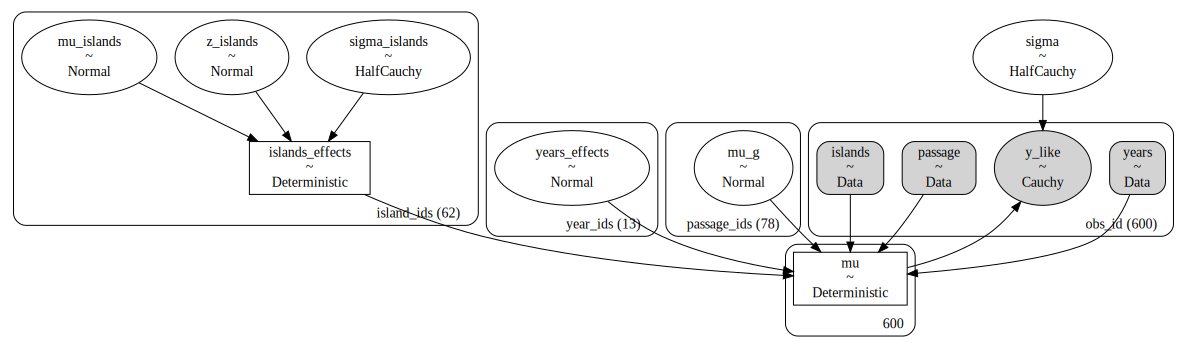

In [10]:
# 0から始まるインデックスを振り直す
df['island_ids'], unique_island_ids = pd.factorize(df['island_ids'])
df['years'], unique_years = pd.factorize(df['years'])

# 次元の定義
coords = {
    'island_ids': unique_island_ids,
    'year_ids': unique_years,
    'passage_ids': df['passage_of_year'].unique(),
    'obs_id': df.index
}

with pm.Model(coords=coords) as twfe:
    # data
    islands = pm.Data('islands', df['island_ids'], dims='obs_id')
    years = pm.Data('years', df['years'], dims='obs_id')
    passage = pm.Data('passage', df['passage_of_year'], dims='obs_id')

    # hyperparameters
    mu_islands = pm.Normal('mu_islands', mu=0, sigma=100, dims='island_ids')
    sigma_islands = pm.HalfCauchy('sigma_islands', beta=1000000, dims='island_ids')

    # priors
    years_effects = pm.Normal('years_effects', mu=0, sigma=100, dims='year_ids')
    mu_g = pm.Normal('mu_g', mu=0, sigma=100, dims='passage_ids')

    # random intercept
    z_islands = pm.Normal('z_islands', mu=0, sigma=1, dims='island_ids')
    islands_effects = pm.Deterministic('islands_effects', mu_islands + z_islands * sigma_islands, dims='island_ids')

    # model error
    sigma = pm.HalfCauchy('sigma', beta=1000000)

    # expectation
    mu = pm.Deterministic('mu', islands_effects[islands] + years_effects[years] + mu_g[passage])

    # likelihood
    y_like = pm.Cauchy('y_like', alpha=mu, beta=sigma, observed=df['population_change_rate'].values, dims='obs_id')

pm.model_to_graphviz(twfe)

In [74]:
with twfe:
    idata_twfe = pm.sample(draws=2000, tune=1000, nuts_sampler='numpyro', random_seed=123)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

There were 482 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [75]:
az.summary(idata_twfe)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_islands[0],-0.146,93.906,-176.256,181.157,1.027,1.121,8337.0,5296.0,1.0
mu_islands[1],2.681,95.669,-179.914,187.541,1.166,1.237,6739.0,5284.0,1.0
mu_islands[2],1.692,95.839,-175.922,186.900,1.096,1.188,7636.0,5740.0,1.0
mu_islands[3],-1.038,97.328,-184.198,188.909,1.012,1.137,9181.0,6144.0,1.0
mu_islands[4],2.571,97.418,-186.785,178.861,1.131,1.264,7445.0,4885.0,1.0
...,...,...,...,...,...,...,...,...,...
mu[595],-12.885,1.986,-16.554,-9.121,0.023,0.016,7529.0,6872.0,1.0
mu[596],-5.221,2.423,-9.747,-0.698,0.036,0.026,4542.0,2091.0,1.0
mu[597],-13.404,1.940,-17.087,-9.800,0.022,0.016,7486.0,5917.0,1.0
mu[598],-13.469,2.084,-17.430,-9.625,0.024,0.017,7749.0,6385.0,1.0


array([[<Axes: title={'center': 'mu_islands'}>,
        <Axes: title={'center': 'mu_islands'}>],
       [<Axes: title={'center': 'islands_effects'}>,
        <Axes: title={'center': 'islands_effects'}>],
       [<Axes: title={'center': 'years_effects'}>,
        <Axes: title={'center': 'years_effects'}>],
       [<Axes: title={'center': 'mu_g'}>,
        <Axes: title={'center': 'mu_g'}>],
       [<Axes: title={'center': 'sigma_islands'}>,
        <Axes: title={'center': 'sigma_islands'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>]],
      dtype=object)

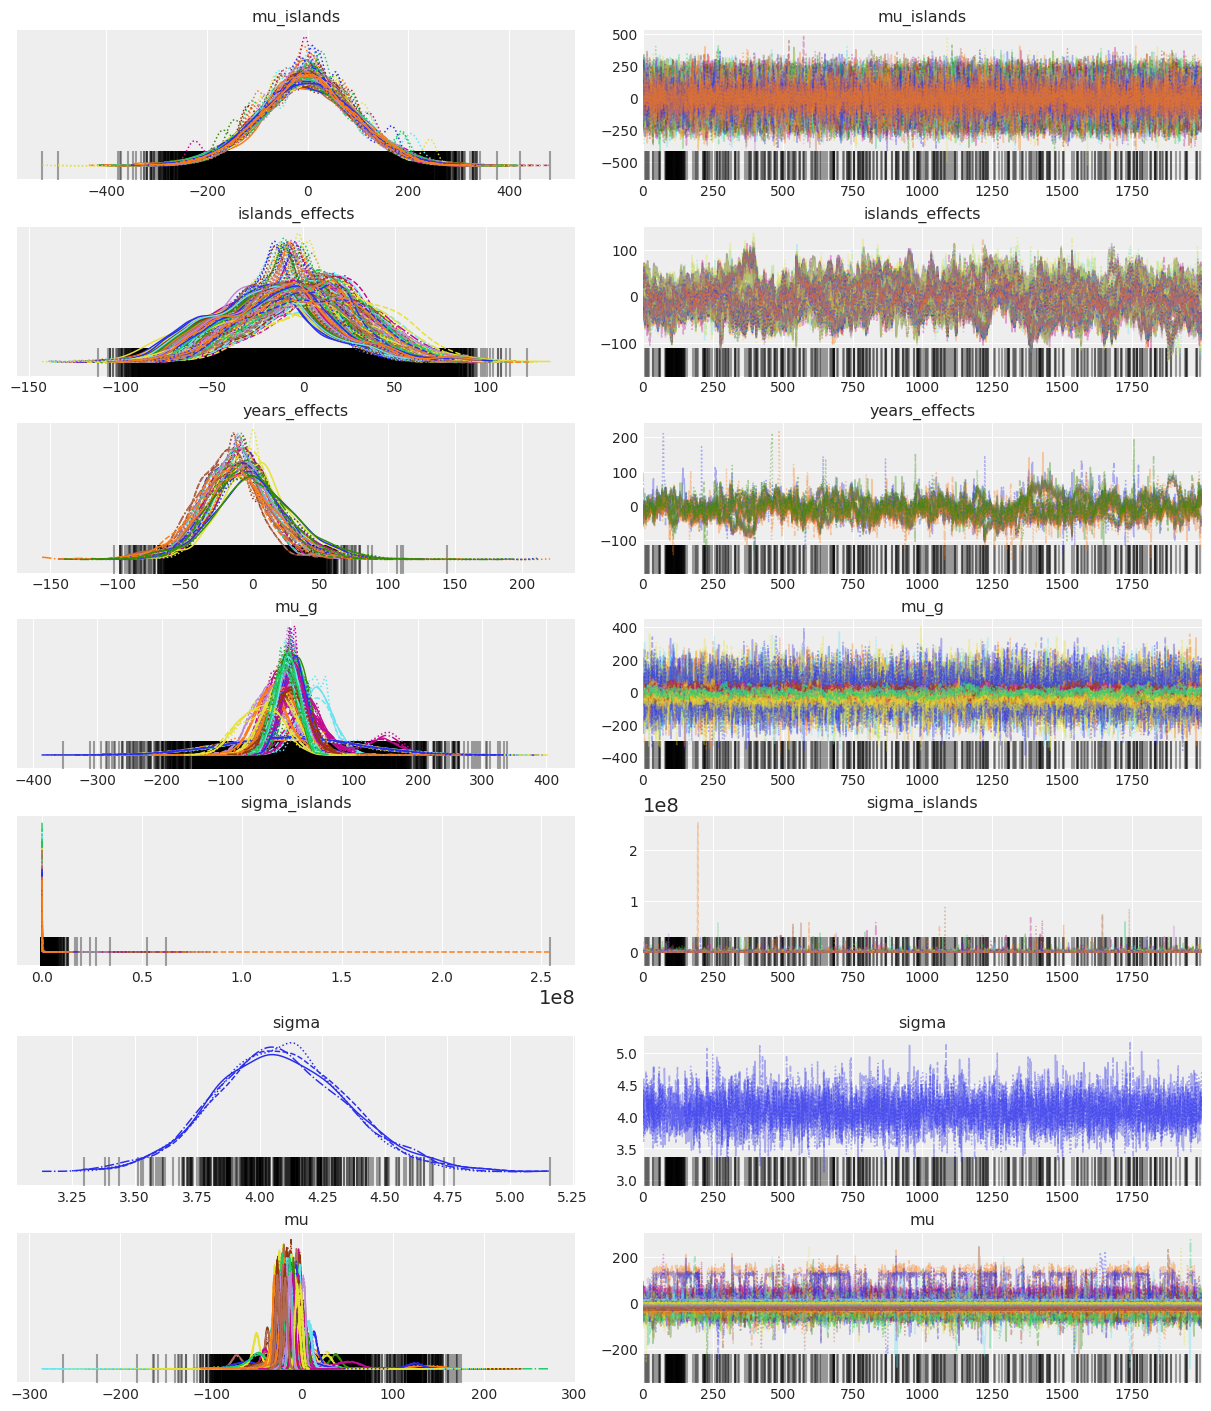

In [76]:
az.plot_trace(idata_twfe)

In [70]:
summary = az.summary(idata_twfe, var_names=['mu_g'], hdi_prob=.95)
print(summary)

             mean      sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
mu_g[-40]  -1.040  16.088   -33.069     28.892      0.562    0.397     836.0   
mu_g[-35]   2.419  22.226   -41.667     46.911      0.616    0.498    1304.0   
mu_g[-30]  11.984  17.832   -22.166     46.758      0.626    0.443     817.0   
mu_g[-25] -22.363  22.515   -71.220     19.955      0.691    0.489    1111.0   
mu_g[-20]  -3.788  17.540   -36.911     30.582      0.615    0.458     818.0   
...           ...     ...       ...        ...        ...      ...       ...   
mu_g[-21]   1.839  16.181   -28.347     34.205      0.566    0.401     832.0   
mu_g[-36]   0.293  22.109   -43.680     43.268      0.612    0.489    1308.0   
mu_g[-31]  -1.956  17.951   -35.511     32.443      0.624    0.458     835.0   
mu_g[-26] -44.469  33.445  -111.041     16.116      0.974    0.689    1185.0   
mu_g[-41]  -4.201  17.531   -36.685     30.903      0.621    0.458     800.0   

           ess_tail  r_hat  
mu_g[-40] 

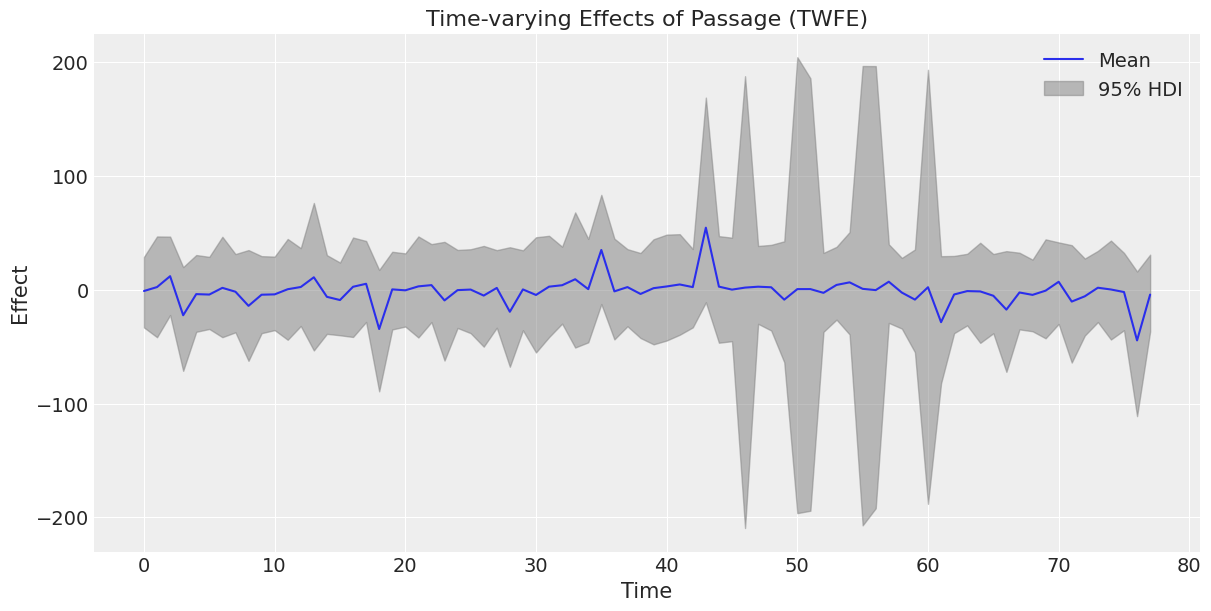

In [72]:
# beta_passageの事後分布を抽出
beta_passage_posterior = idata_twfe.posterior['mu_g']

# 事後分布の平均と信用区間を計算
beta_passage_mean = beta_passage_posterior.mean(dim=["chain", "draw"]).values
beta_passage_hdi = az.hdi(beta_passage_posterior, hdi_prob=0.95)

# HDIの下限と上限を抽出
beta_passage_hdi_lower = beta_passage_hdi.sel(hdi='lower').to_array().values.flatten()
beta_passage_hdi_upper = beta_passage_hdi.sel(hdi='higher').to_array().values.flatten()

# プロットの作成
plt.figure(figsize=(12, 6))
plt.plot(beta_passage_mean, label='Mean')
plt.fill_between(
    range(len(beta_passage_mean)),
    beta_passage_hdi_lower,
    beta_passage_hdi_upper,
    color='gray', alpha=0.5, label='95% HDI'
)

plt.xlabel('Time')
plt.ylabel('Effect')
plt.title('Time-varying Effects of Passage (TWFE)')
plt.legend()
plt.show()

### Staggered DiD

$$
\mu_{it} = \beta_c + (\beta_\Delta \cdot \text{group}_i) + (\text{trend}_t \cdot t_i) + (\Delta \cdot \text{treated}_i \cdot \text{group}_i)
$$

$$
\mu_{it} = \text{TreatmentGroup} + \text{Year}_t + \text{PassageOfYear} \times \text{Cohort}
$$

$$
\mu_{it} = \beta_c + \sum_{g \in G} \beta_{group} \cdot 1(g_i = g) + \gamma_{year} + \sum_{k \geq 0} \delta_k \cdot D_{it}^k
$$

- $\beta_c$:
  - 基本の切片（元の式と同様）
- $\sum_{g \in G} \beta_g \cdot 1(g_i = g)$:
  - グループ固定効果
  - $G$は処置時期の集合
  - $1(g_i = g)$はグループ$g$に属する場合1となる指示関数
  - 処置タイミングでグループを分類
- $\gamma_{year}$:
  - 年固定効果（元の式の$\text{trend}_t \cdot t_i$をより柔軟に）
- $\sum_{k \geq 0} \delta_k \cdot D_{it}^k$:
  - 処置効果
  - $k$は処置からの経過期間
  - $D_{it}^k$は単位$i$が時点$t$で処置から$k$期経過している場合1となる指示関数

$$
\mu_{it} = \alpha_i + \gamma_t + \sum_{g \in G} \sum_{k \geq 0} \delta_{gk} \cdot 1(g_i = g) \cdot D_{it}^k
$$

In [ ]:
def outcome(t, control_intercept, treat_intercept_delta, trend, Δ, group, treated):
    return islands_effects + (treat_intercept_delta * group) + (t * trend) + (Δ * treated * group)

$$
\mu_i = \beta_c + (\beta_\Delta \cdot \text{group}_i) + (\text{year} \cdot t_i) + (\Delta \cdot \text{treated}_i \cdot \text{group}_i)
$$

In [13]:
def is_treated(t, intervention_time, group):
    return (t > intervention_time) * group

In [14]:
# true parameters
control_intercept = 1
treat_intercept_delta = 0.25
trend = 1
Δ = 0.5
intervention_time = 0.5

In [16]:
with pm.Model() as model:
    # data

    # Priors
    treatment_group = pm.Normal('treatment_group', mu=0, sigma=100)
    beta_cohort_passage = pm.Normal('beta_cohort_passage', mu=0, sigma=100, shape=(n_cohort))
    islands_effects = pm.Normal('islands_effects', mu=0, sigma=100, shape=n_islands, dims='islands')
    years_effects = pm.Normal('years_effects', mu=0, sigma=100, shape=n_years, dims='years')
    sigma = pm.InverseGamma('sigma', alpha=0.001, beta=0.001)

    # expectation
    mu = pm.Deterministic('mu', outcome(), dims='obs_idx')

    # Likelihood
    pm.Normal('obs', mu=mu, sigma=sigma, observed=y, dims='obs_idx')

# モデルの視覚化
pm.model_to_graphviz(model)

TypeError: outcome() missing 7 required positional arguments: 't', 'control_intercept', 'treat_intercept_delta', 'trend', 'Δ', 'group', and 'treated'

In [28]:
with model:
    idata = pm.sample(
        draws=8000,
        tune=2000,
        nuts_sampler="numpyro",
        return_inferencedata=True,
        init="adapt_diag",
    )

ValueError: Incompatible Elemwise input shapes [(20,), (97,)]

In [62]:
az.to_netcdf(idata, 'bm_twfe.nc')

'bm_twfe.nc'

In [26]:
az.summary(idata, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_treatment,-3.731,27.274,-55.413,50.194,0.471,0.333,3363.0,4742.0,1.00
beta_passage[0],7.528,24.204,-40.440,53.893,0.354,0.251,4661.0,8913.0,1.00
beta_passage[1],-17.364,21.225,-57.692,25.130,0.383,0.271,3072.0,7081.0,1.00
beta_passage[2],7.019,22.914,-37.262,51.786,0.351,0.248,4262.0,7799.0,1.00
beta_passage[3],13.954,21.353,-29.198,54.281,0.387,0.273,3054.0,6924.0,1.00
...,...,...,...,...,...,...,...,...,...
years_effects[9],1.577,19.456,-36.253,39.910,0.390,0.276,2490.0,4207.0,1.01
years_effects[10],-6.787,19.445,-44.335,31.908,0.390,0.276,2489.0,4097.0,1.01
years_effects[11],-7.472,19.441,-45.777,30.460,0.389,0.275,2500.0,4265.0,1.01
years_effects[12],-11.945,19.439,-50.192,26.125,0.389,0.275,2504.0,4190.0,1.01


In [55]:
az.summary(idata, var_names=['beta_passage'], hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_passage[0],7.528,24.204,-40.440,53.893,0.354,0.251,4661.0,8913.0,1.0
beta_passage[1],-17.364,21.225,-57.692,25.130,0.383,0.271,3072.0,7081.0,1.0
beta_passage[2],7.019,22.914,-37.262,51.786,0.351,0.248,4262.0,7799.0,1.0
beta_passage[3],13.954,21.353,-29.198,54.281,0.387,0.273,3054.0,6924.0,1.0
beta_passage[4],4.555,22.877,-39.731,49.686,0.352,0.249,4241.0,8052.0,1.0
...,...,...,...,...,...,...,...,...,...
beta_passage[72],-1.720,26.063,-52.498,49.621,0.364,0.257,5124.0,8332.0,1.0
beta_passage[73],3.309,24.861,-44.217,53.456,0.349,0.247,5064.0,9333.0,1.0
beta_passage[74],-5.735,22.198,-49.198,37.708,0.364,0.258,3712.0,8398.0,1.0
beta_passage[75],2.865,25.969,-48.746,53.053,0.362,0.256,5151.0,8712.0,1.0


array([[<Axes: title={'center': 'beta_treatment'}>,
        <Axes: title={'center': 'beta_treatment'}>],
       [<Axes: title={'center': 'beta_passage'}>,
        <Axes: title={'center': 'beta_passage'}>],
       [<Axes: title={'center': 'islands_effects'}>,
        <Axes: title={'center': 'islands_effects'}>],
       [<Axes: title={'center': 'years_effects'}>,
        <Axes: title={'center': 'years_effects'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

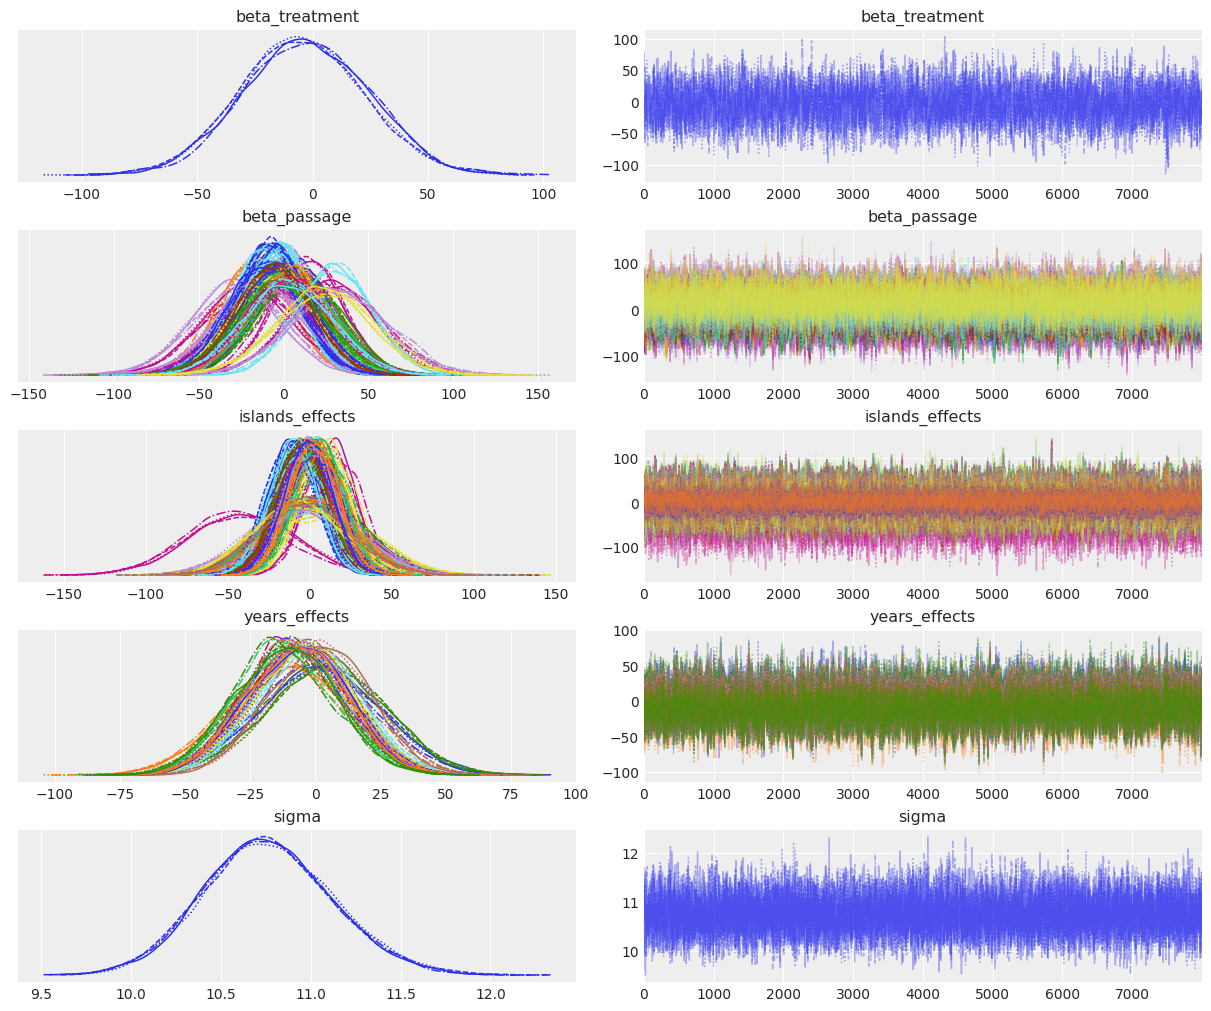

In [27]:
az.plot_trace(idata)

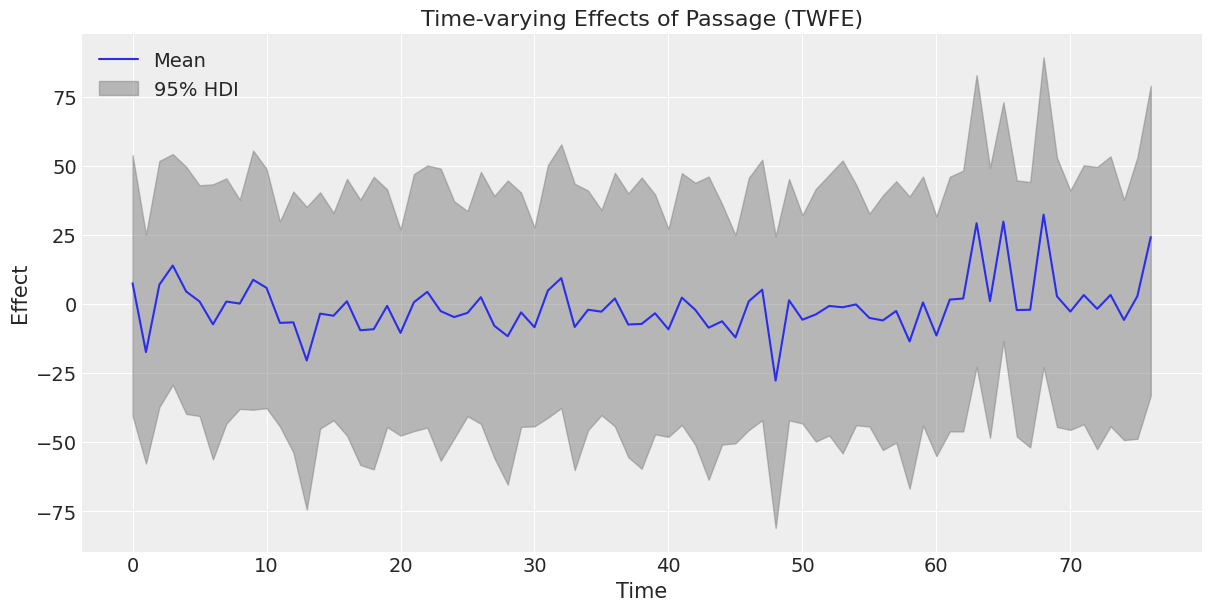

In [ ]:
# beta_passageの事後分布を抽出
beta_passage_posterior = idata.posterior['beta_passage']

# 事後分布の平均と信用区間を計算
beta_passage_mean = beta_passage_posterior.mean(dim=["chain", "draw"]).values
beta_passage_hdi = az.hdi(beta_passage_posterior, hdi_prob=0.95)

# HDIの下限と上限を抽出
beta_passage_hdi_lower = beta_passage_hdi.sel(hdi='lower').to_array().values.flatten()
beta_passage_hdi_upper = beta_passage_hdi.sel(hdi='higher').to_array().values.flatten()

# プロットの作成
plt.figure(figsize=(12, 6))
plt.plot(beta_passage_mean, label='Mean')
plt.fill_between(
    range(len(beta_passage_mean)),
    beta_passage_hdi_lower,
    beta_passage_hdi_upper,
    color='gray', alpha=0.5, label='95% HDI'
)

plt.xlabel('Time')
plt.ylabel('Effect')
plt.title('Time-varying Effects of Passage (TWFE)')
plt.legend()
plt.show()

In [6]:
idata = az.from_netcdf('./bm_twfe_sampling.nc')

In [8]:
posterior_samples = idata.posterior

# 0以上のサンプルの割合を計算
prob_beta_bridge_positive = np.mean(posterior_samples['beta_passage'] > 0)
print(f"Pr(beta_passage > 0) = {prob_beta_bridge_positive:.4f}")
prob_sigma_positive = np.mean(posterior_samples['sigma'] > 0)
print(f"Pr(sigma > 0) = {prob_sigma_positive:.4f}")

Pr(beta_passage > 0) = 0.4786
Pr(sigma > 0) = 1.0000
